<a href="https://colab.research.google.com/github/tackulus/229352/blob/main/Lab08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Lab 08**

---

> **229352 Statistical Learning for Data Science 2**

> **Kasidis Torcharoen (610510531)**

In [2]:
!git clone https://github.com/tackulus/229352.git

Cloning into '229352'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 99 (delta 41), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (99/99), done.


In [88]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [113]:
data = pd.read_csv("/content/229352/dataset/chiang_mai_1998-2019.csv")
data.head()

,Date,MaximumPressure,MinimumPressure,MaximumTemperature,MinimumTemperature,MaximumRelativeHumidity,MinimumRelativeHumidity,Precipitation,TotalEvaporation,SunshineDuration,WindDirection,WindSpeed
0,1998-01-01,1016.3,1010.9,30.6,15.6,96,39,0.0,3.55,8.3,30,4.629996
1,1998-01-02,1017.0,1011.9,32.0,14.8,96,34,0.0,1.56,8.9,350,5.658884
2,1998-01-03,1017.3,1011.6,31.6,14.9,97,37,0.0,5.83,8.9,190,9.774436
3,1998-01-04,1018.0,1012.3,32.1,14.2,93,36,0.0,3.55,8.8,70,5.658884
4,1998-01-05,1017.7,1012.3,31.2,14.8,94,49,0.0,2.75,7.9,230,5.658884


In [114]:
data.shape

(7882, 12)

1. Encode the row index into sine and cosine features with one-year cycle (note: one year consists of 365.25 days in this context) with the following transformation.

In [115]:
data['CosIndex'] = np.cos(2 * np.pi * data.index / 365.25)
data['SinIndex'] = np.sin(2 * np.pi * data.index / 365.25)
data.shape

(7882, 14)

2. Transform the wind speed (r) and wind direction (θ,0≤θ≤359) into rectangular coordinates.

In [116]:
data['WindX'] = data.WindSpeed * np.cos(2 * np.pi * data.WindDirection / 360)
data['WindY'] = data.WindSpeed * np.sin(2 * np.pi * data.WindDirection / 360)
data.drop(columns=['WindDirection', 'WindSpeed'], inplace=True)
data.shape

(7882, 14)

3.  Split the data
    - Training set : 1998-01-01 to 2013-12-31
    - Validation set : 2014-01-01 to 2016-12-31
    - Test set : 2017-01-01 to 2019-07-31

In [122]:
copy = data.astype({'Date': 'datetime64'})
copy.set_index('Date', inplace=True)
train = copy['1998-01-01':'2013-12-31']
valid = copy['2014-01-01':'2016-12-31']
test  = copy['2017-01-01':'2019-07-31']
for df in [train, valid, test, copy]: 
    df.reset_index(drop=True, inplace=True)

train.shape, valid.shape, test.shape

((5844, 13), (1096, 13), (942, 13))

4. Normalize the training set using sklearn.preprocessing.StandardScaler, then use the fitted scaler to normalize the validation and the test set.

In [123]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(train)

train = scaler.transform(train)
train = pd.DataFrame(train)
train.columns = copy.columns

valid = scaler.transform(valid)
valid = pd.DataFrame(valid)
valid.columns = copy.columns

test = scaler.transform(test)
test = pd.DataFrame(test)
test.columns = copy.columns

In [127]:
test

,MaximumPressure,MinimumPressure,MaximumTemperature,MinimumTemperature,MaximumRelativeHumidity,MinimumRelativeHumidity,Precipitation,TotalEvaporation,SunshineDuration,CosIndex,SinIndex,WindX,WindY
0,2.176661,1.731829,-3.129358,-0.496215,0.483026,1.442954,0.175032,-1.620820,-2.048605,1.414200,0.006082,1.371945,0.327500
1,1.672939,1.318661,-1.217635,-0.357507,0.604956,0.683059,-0.346761,-1.126611,-0.014690,1.413887,0.030408,1.104971,0.858522
2,1.422261,0.938864,-0.591381,-0.107831,0.117236,0.746383,-0.346761,-1.347552,-0.922129,1.413154,0.054724,-0.294563,1.141073
3,1.067527,1.053280,-2.536064,0.252812,0.117236,1.189656,-0.346761,-0.795200,-2.048605,1.412004,0.079024,2.648374,-0.650456
4,1.199961,1.250329,-3.063436,-0.385248,0.604956,1.696253,-0.005999,-1.696405,-2.048605,1.410436,0.103301,1.496221,0.568667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,-0.294651,0.177682,-2.008693,0.502487,0.483026,2.519473,0.419955,-2.417368,-2.048605,-1.294165,-0.570208,-0.704062,0.746624
938,-0.602087,-0.362615,0.628166,0.474745,0.726886,0.176462,-0.346761,0.879296,0.517257,-1.284165,-0.592385,-0.892883,0.086332
939,-0.767629,-0.426179,0.694087,1.029580,-0.248555,0.176462,-0.346761,0.518814,0.266929,-1.273785,-0.614387,-1.010138,-0.932813
940,-1.004118,-0.537417,0.397441,1.251514,0.117236,0.493085,1.016290,0.065305,-1.798277,-1.263028,-0.636207,-0.872387,-0.448610


5. Use moving-window transformation to transform each set into feature-target pairs (X,y), where X consists of all features in the past 5 days and y is the precipitation in the next 3 days. No need to shuffle the data.

In [153]:
def make_dataset(data, window_size=5, future=3):
    target = np.array([data[i:future+i] for i in range(len(data)-future)])
    target = np.r_[target, np.zeros((future, future, data.shape[1]))]
    dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=target,
            sequence_length=window_size,
            sequence_stride=1,
            shuffle=False,
            batch_size=10)
    
    X, y = next(iter(dataset))
    print(">>", X.shape, y.shape)

    return dataset
    
train_batch = make_dataset(train)
valid_batch = make_dataset(valid)
test_batch  = make_dataset(test)

>> (10, 5, 13) (10, 3, 13)
>> (10, 5, 13) (10, 3, 13)
>> (10, 5, 13) (10, 3, 13)


6. Build an LSTM Encoder-Decoder model, which takes a sequence of length 5 as an input and returns a sequence of length 3. You might also add some Dense layers at the end of the network.

In [154]:
from tensorflow.keras.layers import Dense, Input, Flatten, GRU, LSTM, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.compat.v1.keras.layers import CuDNNLSTM

inps = Input(shape=(5,13))
encoder = CuDNNLSTM(units=100, 
                    return_sequences=True,
                    return_state=True)

x, state_h, state_c = encoder(inps)
x = RepeatVector(3)(state_h)

decoder = CuDNNLSTM(units=100, 
                    return_sequences=True,
                    return_state=True)

x, *_ = decoder(x, [state_h, state_c])

outs = Dense(13)(x)
model = Model(inputs=inps, outputs=outs)

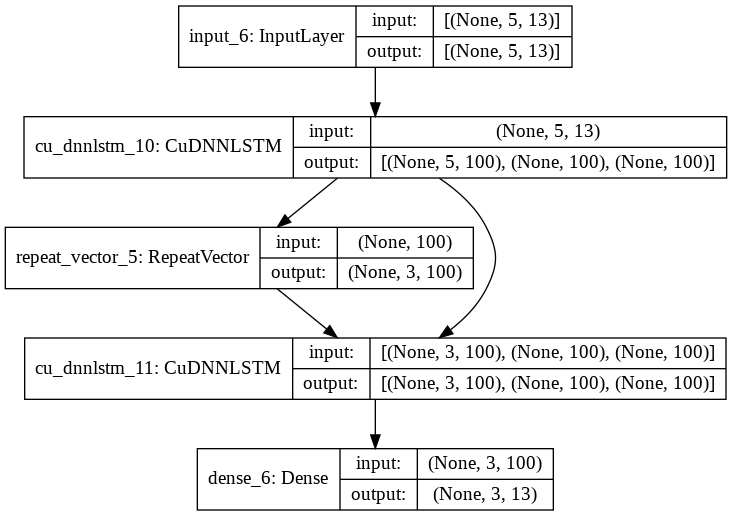

In [155]:
tf.keras.utils.plot_model(model, show_shapes=True)

7. Choose your own optimizer, learning rate and batch size. Train the model using the mean-squared error (MSE) as the loss function and the mean absolute error (MAE) as the metric. While training, keep track of the MSE and MAE of the predictions of the validation set by setting validation_data= (Xval,yval) in model.fit’s argument.

In [156]:
model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(learning_rate=0.001),
              metrics=[tf.metrics.MeanAbsoluteError()])

model.fit(train_batch, validation_data=valid_batch, epochs=10)

Epoch 1/10
584/584 [==============================] - 8s 11ms/step - loss: 0.4635 - mean_absolute_error: 0.4548 - val_loss: 0.3707 - val_mean_absolute_error: 0.4307
Epoch 2/10
584/584 [==============================] - 6s 11ms/step - loss: 0.3320 - mean_absolute_error: 0.3717 - val_loss: 0.2850 - val_mean_absolute_error: 0.3652
Epoch 3/10
584/584 [==============================] - 6s 11ms/step - loss: 0.2980 - mean_absolute_error: 0.3527 - val_loss: 0.2489 - val_mean_absolute_error: 0.3353
Epoch 4/10
584/584 [==============================] - 6s 11ms/step - loss: 0.2615 - mean_absolute_error: 0.3283 - val_loss: 0.2878 - val_mean_absolute_error: 0.3832
Epoch 5/10
584/584 [==============================] - 6s 11ms/step - loss: 0.2388 - mean_absolute_error: 0.3123 - val_loss: 0.2178 - val_mean_absolute_error: 0.3152
Epoch 6/10
584/584 [==============================] - 6s 11ms/step - loss: 0.2340 - mean_absolute_error: 0.3185 - val_loss: 0.2215 - val_mean_absolute_error: 0.3224
Epoch 7/10

8. Make predictions (i.e. forecasts of normalized precipitation for the next three days) on the test set. Then plot time series of the next-day forecast and the actual next-day precipitation.

In [168]:
x_test,y_test = next(iter(test_batch))
y_test_pred = model.predict(x_test)
y_test = scaler.inverse_transform(y_test).reshape((30, 13))
y_test_pred = scaler.inverse_transform(y_test_pred).reshape((30, 13))

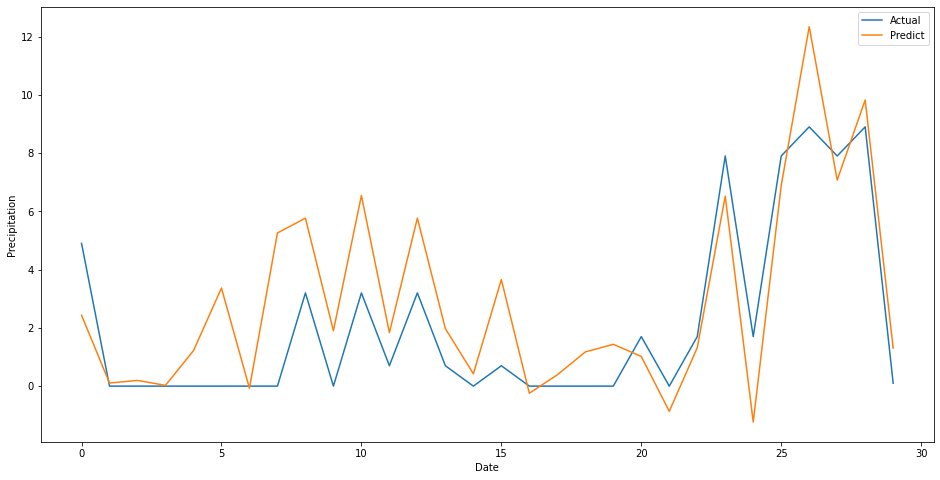

In [171]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16,8))
df = pd.DataFrame(y_test)
df.columns = copy.columns
preci1 = df.Precipitation
preci1.plot()
df = pd.DataFrame(y_test_pred)
df.columns = copy.columns
preci2 = df.Precipitation
preci2.plot()

plt.legend(["Actual", "Predict"])
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.show()

9. Does the model underestimate or overestimate precipitation, and why might that be the case?

In [175]:
from sklearn.metrics import mean_absolute_error as MAE 

mae = MAE(preci1, preci2)
mae

1.5252465543150902

The model estimate precipitation with average error of 1.52.